In [31]:
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import qutip as qt
from numpy import linalg
import scipy
from scipy.linalg import fractional_matrix_power,expm, null_space
from scipy.optimize import fsolve
import itertools
from itertools import product
import cmath
import qutip as qt
from qutip import *

np.set_printoptions(precision=8,suppress=True)

In [32]:
#first define some useful 3x3 matrices
Sx = np.array([[0,1,1],[1,0,1],[1,1,0]])
I3 = np.eye(3)
I5 = np.eye(5)
I2 = np.eye(2)
Sy = np.array([[0,1,-1],[-1,0,1],[1,-1,0]])
S3 = np.array([[0,0,1],[1,0,0],[0,1,0]])
#svd example
e = 1.602*10**(-19)#C
hbar = 1.054*10**(-34)#Js
h = hbar*2*np.pi
phi0 = hbar/2/e

In [33]:
# Change the parameters and run the file to see the resulting dynamics.
#Parameters
Cj = np.double(100.0*10**(-6))#nF
Cc = np.double(10.0*1e-6)#nF
Cg = np.double(1.5*Cj)
R = np.double(50.0*10**(0))#Ohm
phi =np.pi/3
beta = np.pi/3+0.1

# Run all

## Constructing the classical Hamiltonians

In [34]:
def Dinf(Cj,Cc,Cg,R):
    return (Cj+Cc*Cg/(Cc+Cg))*I3
def YacR(Cj,Cc,Cg,R,s,phi):
    num = Cc**2*s
    den = 3*(Cc+Cg)+3*(Cc+Cg)**3*R**2*s**2/np.tan(phi/2)**2
    alpha = num/den
    return alpha*np.array([[2,-1,-1],[-1,2,-1],[-1,-1,2]])
def YacNR(Cj,Cc,Cg,R,s,phi):
    num = Cc**2*np.tan(phi/2)**3
    den = np.sqrt(3)*(Cc+Cg)**2*R*((Cc+Cg)**2*R**2*s**2+np.tan(phi/2)**2)
    beta = num/den
    return beta*np.array([[0,-1,1],[1,0,-1],[-1,1,0]])
def Yac(Cj,Cc,Cg,R,s,phi):
    return YacR(Cj,Cc,Cg,R,s,phi)+YacNR(Cj,Cc,Cg,R,s,phi)
def Einf(Cj,Cc,Cg,R,phi):
    a = Cc**2*np.tan(phi/2)/(Cc+Cg)**2/R/np.sqrt(3)
    return a*np.array([[0,1,-1],[-1,0,1],[1,-1,0]])
def Ymat(Cj,Cc,Cg,R,s,phi):
    return Einf(Cj,Cc,Cg,R,phi)+Dinf(Cj,Cc,Cg,R)*s+Yac(Cj,Cc,Cg,R,s,phi)


def A0mat(Cj,Cc,Cg,R):
    Cj1 = (2/(Cc+Cj)+(Cc+Cg)/(Cg*Cj+Cc*(Cg+Cj)))/3
    Ck = Cc**2/3/(Cc+Cj)/(Cg*Cj+Cc*(Cg+Cj))
    return Cj1*I3+Ck*np.array([[0,1,1],[1,0,1],[1,1,0]])
def ZacR(Cj,Cc,Cg,R,s,phi):
    k1 = Cg*Cj+Cc*(Cg+Cj)
    num = Cc**2*k1*R**2*s
    den = 3*(Cc+Cj)*(k1**2*R**2*s**2+(Cc+Cj)**2*np.tan(phi/2)**2)
    alpha = num/den
    return alpha*np.array([[2,-1,-1],[-1,2,-1],[-1,-1,2]])
def ZacNR(Cj,Cc,Cg,R,s,phi):
    k1 = Cg*Cj+Cc*(Cg+Cj)
    num = Cc**2*R*np.tan(phi/2)
    den = np.sqrt(3)*(k1**2*R**2*s**2+(Cc+Cj)**2*np.tan(phi/2)**2)
    beta = num/den
    return beta*np.array([[0,-1,1],[1,0,-1],[-1,1,0]])
def Zac(Cj,Cc,Cg,R,s,phi):
    return ZacR(Cj,Cc,Cg,R,s,phi)+ZacNR(Cj,Cc,Cg,R,s,phi)
def Zmat(Cj,Cc,Cg,R,s,phi):
    return A0mat(Cj,Cc,Cg,R)/s+Zac(Cj,Cc,Cg,R,s,phi)

def OmegamatY(Cj,Cc,Cg,R,Ldiag):
    CJ = np.diag(Dinf(Cj,Cc,Cg,R))
    print(CJ)
    return (CJ*Ldiag)**(-1/2)
def OmegamatZ(Cj,Cc,Cg,R,Ldiag):
    CJ = np.diag(np.linalg.inv(A0mat(Cj,Cc,Cg,R)))
    return (CJ*Ldiag)**(-1/2)

def A0bar(Cj,Cc,Cg,R,Ldiag):
    A0 = A0mat(Cj,Cc,Cg,R)
    OmegaJ = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    Lj = Ldiag[0]
    wj = OmegaJ[0]
    return 1/Lj/wj*A0

def Ybar(Cj,Cc,Cg,R,s,phi):
    CjmatI = np.diag(np.linalg.inv(Dinf(Cj,Cc,Cg,R)))
    return np.matmul(np.diag(np.sqrt(CjmatI)),np.matmul(Ymat(Cj,Cc,Cg,R,s,phi),np.diag(np.sqrt(CjmatI))))
def Yacbar(Cj,Cc,Cg,R,s,phi):
    CjmatI = np.diag(np.linalg.inv(Dinf(Cj,Cc,Cg,R)))
    return np.matmul(np.diag(np.sqrt(CjmatI)),np.matmul(Yac(Cj,Cc,Cg,R,s,phi),np.diag(np.sqrt(CjmatI))))
def YbarR(Cj,Cc,Cg,R,s,phi):
    return (Ybar(Cj,Cc,Cg,R,s,phi)+Ybar(Cj,Cc,Cg,R,s,phi).T)/2
def YacbarR(Cj,Cc,Cg,R,s,phi):
    return (Yacbar(Cj,Cc,Cg,R,s,phi)+Yacbar(Cj,Cc,Cg,R,s,phi).T)/2
def YbarNR(Cj,Cc,Cg,R,s,phi):
    return (Ybar(Cj,Cc,Cg,R,s,phi)-Ybar(Cj,Cc,Cg,R,s,phi).T)/2
def Einfbar(Cj,Cc,Cg,R,phi):
    CjmatI = np.diag(np.linalg.inv(Dinf(Cj,Cc,Cg,R)))
    return np.matmul(np.diag(np.sqrt(CjmatI)),np.matmul(Einf(Cj,Cc,Cg,R,phi),np.diag(np.sqrt(CjmatI))))

def Zbar(Cj,Cc,Cg,R,s,phi):
    #perturbative approach, see apendix C2 and C4
    Cjmat = scipy.linalg.sqrtm(np.linalg.inv(A0mat(Cj,Cc,Cg,R)))
    return np.matmul(Cjmat,np.matmul(Zmat(Cj,Cc,Cg,R,s,phi),Cjmat))
def Zacbar(Cj,Cc,Cg,R,s,phi):
    #perturbative approach
    Cjmat = scipy.linalg.sqrtm(np.linalg.inv(A0mat(Cj,Cc,Cg,R)))
    return np.matmul(Cjmat,np.matmul(Zac(Cj,Cc,Cg,R,s,phi),Cjmat))
def ZbarR(Cj,Cc,Cg,R,s,phi):
    return (Zbar(Cj,Cc,Cg,R,s,phi)+Zbar(Cj,Cc,Cg,R,s,phi).T)/2
def ZacbarR(Cj,Cc,Cg,R,s,phi):
    return (Zacbar(Cj,Cc,Cg,R,s,phi)+Zacbar(Cj,Cc,Cg,R,s,phi).T)/2
def ZbarNR(Cj,Cc,Cg,R,s,phi):
    return (Zbar(Cj,Cc,Cg,R,s,phi)-Zbar(Cj,Cc,Cg,R,s,phi).T)/2
def Zdcbar(Cj,Cc,Cg,R,Ldiag,s):
    A = A0bar(Cj,Cc,Cg,R,Ldiag)
    return A/s

def wgy(Cj,Cc,Cg,R,phi):
    return np.tan(phi/2)/(Cc+Cg)/R

def wgz(Cj,Cc,Cg,R,phi):
    num = (Cc+Cj)*np.tan(phi/2)
    den = (Cg*Cj+Cc*(Cg+Cj))*R
    return num/den

def wplasmon(Cj,Cc,Cg,R,Lj):
    return 1/np.sqrt(Lj*(Cj+Cc))/2/np.pi

In [35]:
#build the exact Y, Z responses hamiltonian following appendices A and D. 
def nlnr_Z(Cj,Cc,Cg,R):
    beta = Cc**2/(Cc+Cj)/(Cg*Cj+Cc*(Cg+Cj))/3
    theta = np.pi/3
    n1l = np.sqrt(2*beta)*np.cos(theta+0)
    n2l = np.sqrt(2*beta)*np.cos(theta+2*np.pi/3)
    n3l = np.sqrt(2*beta)*np.cos(theta-2*np.pi/3)
    n1r = np.sqrt(2*beta)*np.sin(theta+0)
    n2r = np.sqrt(2*beta)*np.sin(theta+2*np.pi/3)
    n3r = np.sqrt(2*beta)*np.sin(theta-2*np.pi/3)
    nl = np.array([[n1l],[n2l],[n3l]])
    nr = np.array([[n1r],[n2r],[n3r]])
    return nl, nr
def N_Z(Cj,Cc,Cg,R):
    beta = Cc**2/(Cc+Cj)/(Cg*Cj+Cc*(Cg+Cj))/3
    theta = np.pi/3
    n1l = np.sqrt(2*beta)*np.cos(theta+0)
    n2l = np.sqrt(2*beta)*np.cos(theta-2*np.pi/3)
    n3l = np.sqrt(2*beta)*np.cos(theta+2*np.pi/3)
    n1r = np.sqrt(2*beta)*np.sin(theta+0)
    n2r = np.sqrt(2*beta)*np.sin(theta-2*np.pi/3)
    n3r = np.sqrt(2*beta)*np.sin(theta+2*np.pi/3)
    return np.array([[n1l,n1r],[n2l,n2r],[n3l,n3r]]).T
def Cmat_Z(Cj,Cc,Cg,R):
    CJ = np.linalg.inv(A0mat(Cj,Cc,Cg,R))
    N = N_Z(Cj,Cc,Cg,R)
    CjN = np.matmul(CJ,N.T)
    NCjN = np.matmul(N,CjN)
    return np.block([[CJ,-CjN],[-CjN.T,I2+NCjN]])
def Gmat_Z(Cj,Cc,Cg,R,phi):
    wg_z = wgz(Cj,Cc,Cg,R,phi)
    Ymat = wg_z*np.array([[0,1],[-1,0]])
    zero32 = np.array([[0,0],[0,0],[0,0]])
    return np.block([[0*I3,zero32],[zero32.T,Ymat]])
def Mmat_Z(Cj,Cc,Cg,R,Ldiag,phi):
    zero32 = np.array([[0,0,0],[0,0,0]]).T
    return np.block([[np.diag(Ldiag**(-1)),zero32],[zero32.T,0*I2]])
def HZ(Cj,Cc,Cg,R,Ldiag,phi):
    G = Gmat_Z(Cj,Cc,Cg,R,phi)
    M = Mmat_Z(Cj,Cc,Cg,R,Ldiag,phi)
    C = Cmat_Z(Cj,Cc,Cg,R)
    CI = np.linalg.inv(C)
    GCG = np.matmul(G.T,np.matmul(CI,G))
    GC = np.matmul(G,CI)
    return np.block([[M+GCG/4,GC/2],[GC.T/2,CI]])
def rescaled_HZ_S(Cj,Cc,Cg,R,Ldiag,phi):
    H = HZ(Cj,Cc,Cg,R,Ldiag,phi)
    zero32 = np.array([[0,0,0],[0,0,0]]).T
    wg = wgz(Cj,Cc,Cg,R,phi)
    CJ = np.diag(np.linalg.inv(A0mat(Cj,Cc,Cg,R)))
    ZJsqrt= np.diag((Ldiag/CJ)**(1/4))
    YJsqrt= np.diag((Ldiag/CJ)**(-1/4))
    Sphi = np.block([[YJsqrt*I3,zero32],[zero32.T,I2*np.sqrt(wg)]])
    Sq = np.block([[ZJsqrt*I3,zero32],[zero32.T,I2/np.sqrt(wg)]])
    S = np.block([[Sphi,0*I5],[0*I5,Sq]])
    SI = np.linalg.inv(S)
    STI = np.linalg.inv(S.T)
    return np.matmul(STI,np.matmul(H,SI)),S

def HZexact_J(Cj,Cc,Cg,R,Ldiag,phi):
    #Following appendix D
    LI = np.diag(Ldiag**(-1))
    CJ = np.linalg.inv(A0mat(Cj,Cc,Cg,R))
    CI = np.linalg.inv(CJ)
    nl, nr = nlnr_Z(Cj,Cc,Cg,R)
    N = N_Z(Cj,Cc,Cg,R)
    NN = np.matmul(N.T,N)
    Omega = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    ZJ = np.diag((Ldiag*Omega)**(1/2))#note is ZJ^{1/2} not ZJ
    YJ = np.linalg.inv(ZJ)
    wg = wgz(Cj,Cc,Cg,R,phi) 
    HJ = np.block([[np.diag(Omega),0*I3],[0*I3,np.matmul(YJ,np.matmul(CI+NN,YJ))]])
    HI = wg*I2
    zero31 = np.array([[0,0,0]]).T
    JJ = np.block([[0*I3,I3],[-I3,0*I3]])
    JI = np.array([[0,1],[-1,0]])
    J = np.block([[JJ,np.zeros((6,2))],[np.zeros((2,6)),JI]])
    nl, nr = np.matmul(YJ,nl), np.matmul(YJ,nr)
    K = np.block([[zero31,zero31],[nr*np.sqrt(wg),nl*np.sqrt(wg)]])    
    return np.block([[HJ,K],[K.T,HI]]),J

def E1_Nz(Cj,Cc,Cg,R,phi):
    nl, nr = nlnr_Z(Cj,Cc,Cg,R)
    wg_z = wgz(Cj,Cc,Cg,R,phi)
    return wg_z*(-np.matmul(nl,nr.T)+np.matmul(nr,nl.T))
def checking_NZ(Cj,Cc,Cg,R,s,phi):
    N = N_Z(Cj,Cc,Cg,R)
    D1 = np.matmul(N.T,N)
    E1 = E1_Nz(Cj,Cc,Cg,R,phi)
    wg_z = wgz(Cj,Cc,Cg,R,phi)
    Zac_R = ZacR(Cj,Cc,Cg,R,s,phi)
    Zac_NR = ZacNR(Cj,Cc,Cg,R,s,phi)
    return np.isclose(D1*s/(wg_z**2+s**2),Zac_R),np.isclose(E1/(wg_z**2+s**2),Zac_NR)

def nlnr_Y(Cj,Cc,Cg,R,phi):
    alpha = Cc**2*np.tan(phi/2)**2/(Cc+Cg)**3/R**2/3
    a = np.sqrt(2*alpha)
    theta = 0
    n1l = a
    n1r = 0
    n2l = -a/2
    n2r = -np.sqrt(3)*a/2
    n3l = -a/2
    n3r = np.sqrt(3)*a/2
    nl = np.array([[n1l],[n2l],[n3l]])
    nr = np.array([[n1r],[n2r],[n3r]])
    return nl, nr
def N_Y(Cj,Cc,Cg,R,phi):
    alpha = Cc**2*np.tan(phi/2)**2/(Cc+Cg)**3/R**2/3
    a = np.sqrt(2*alpha)
    theta = 0
    n1l = a
    n1r = 0
    n2l = -a/2
    n2r = -np.sqrt(3)*a/2
    n3l = -a/2
    n3r = np.sqrt(3)*a/2
    return np.array([[n1l,n1r],[n2l,n2r],[n3l,n3r]])
def E1_N(Cj,Cc,Cg,R,phi):
    nl, nr = nlnr_Y(Cj,Cc,Cg,R,phi)
    wg_y = wgy(Cj,Cc,Cg,R,phi)
    return wg_y*(np.matmul(nl,nr.T)-np.matmul(nr,nl.T))
def checking_NY(Cj,Cc,Cg,R,s,phi):
    N = N_Y(Cj,Cc,Cg,R,phi)
    D1 = np.matmul(N,N.T)
    E1 = E1_N(Cj,Cc,Cg,R,phi)
    wg_y = wgy(Cj,Cc,Cg,R,phi)
    Yac_R = YacR(Cj,Cc,Cg,R,s,phi)
    Yac_NR = YacNR(Cj,Cc,Cg,R,s,phi)
    return np.isclose(D1*s/(wg_y**2+s**2),Yac_R),np.isclose(E1/(wg_y**2+s**2),Yac_NR)
def HJ_Y(Cj,Cc,Cg,R,Ldiag,phi):
    Yjg = Einf(Cj,Cc,Cg,R,phi)
    CJ = Dinf(Cj,Cc,Cg,R)
    CJI = np.linalg.inv(CJ)
    YjgCYjg = np.matmul(Yjg.T,np.matmul(CJI,Yjg))
    YjgC = np.matmul(Yjg,CJI)
    LJI = np.diag(Ldiag**(-1))
    return np.block([[LJI+YjgCYjg/4,YjgC/2],[YjgC.T/2,CJI]])
def K_Y(Cj,Cc,Cg,R,phi):
    N = N_Y(Cj,Cc,Cg,R,phi)
    YJG = Einf(Cj,Cc,Cg,R,phi)
    CJ = Dinf(Cj,Cc,Cg,R)
    CJI = np.linalg.inv(CJ)
    YCN = np.matmul(YJG.T,np.matmul(CJI,N))
    CN = np.matmul(CJI,N)
    zero32 = np.array([[0,0,0],[0,0,0]]).T
    return np.block([[YCN/2,zero32],[-CN,zero32]])
def HI_Y(Cj,Cc,Cg,R,phi):
    wg_y = wgy(Cj,Cc,Cg,R,phi)
    Z = wg_y*np.array([[0,-1],[1,0]])
    ZZ = np.matmul(Z.T,Z)
    N = N_Y(Cj,Cc,Cg,R,phi)
    CJ = Dinf(Cj,Cc,Cg,R)
    CJI = np.linalg.inv(CJ)
    NCN = np.matmul(N.T,np.matmul(CJI,N))
    return np.block([[ZZ/4+NCN,Z/2],[Z.T/2,I2]])
def HY(Cj,Cc,Cg,R,Ldiag,phi):
    HJ = HJ_Y(Cj,Cc,Cg,R,Ldiag,phi)
    K = K_Y(Cj,Cc,Cg,R,phi)
    HI = HI_Y(Cj,Cc,Cg,R,phi)
    return np.block([[HJ,K],[K.T,HI]])


def pcy(Cj,Cc,Cg,R,Ldiag,phi):
    OmegaJ = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    CJ = Dinf(Cj,Cc,Cg,R)
    Cj1 = CJ[0,0]
    wj = np.max(OmegaJ)
    N = N_Y(Cj,Cc,Cg,R,phi)
    wg_y = wgy(Cj,Cc,Cg,R,phi)
    Ky = np.sqrt(wj/wg_y)*N/np.sqrt(Cj1)
    delta = np.abs(wj-wg_y)
    ky = np.max(np.abs(Ky))
    return (ky/delta)**3*ky/wj
def pcz(Cj,Cc,Cg,R,Ldiag,phi):
    OmegaJ = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    CJ = np.linalg.inv(A0mat(Cj,Cc,Cg,R))
    Cj1 = CJ[0,0]
    wj = np.max(OmegaJ)
    N = N_Z(Cj,Cc,Cg,R)
    wg = wgz(Cj,Cc,Cg,R,phi)
    Kz = wj*np.sqrt(wj/wg)*N*np.sqrt(Cj1)
    delta = np.abs(wj-wg)
    kz = np.max(np.abs(Kz))
    return (kz/delta)**3*kz/wj
def pcz2(Cj,Cc,Cg,R,Ldiag,phi):
    OmegaJ = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    CJ = np.linalg.inv(A0mat(Cj,Cc,Cg,R))
    Cj1 = CJ[0,0]
    wj = np.max(OmegaJ)
    N = N_Z(Cj,Cc,Cg,R)
    wg = wgz(Cj,Cc,Cg,R,phi)
    Kz = wj*np.sqrt(wj/wg)*N*np.sqrt(Cj1)
    delta = np.abs(wj-wg)
    kz = np.max(np.abs(Kz))
    return (kz/delta)**2*kz/wj

## Build the exact quantum Hamiltonian

### build the exact Hamiltonian

In [36]:
def a_n_phi_q_bare(N):
    #lets assume J canonical structure and I5
    a1  = tensor(destroy(N),qeye(N),qeye(N),qeye(N))
    a2  = tensor(qeye(N),destroy(N),qeye(N),qeye(N))
    a3  = tensor(qeye(N),qeye(N),destroy(N),qeye(N))
    a4  = tensor(qeye(N),qeye(N),qeye(N),destroy(N))#inner mode
    avec = [a1,a2,a3,a4]
    nvec = []
    phivec = []
    qvec = []
    for i in range(4):
        ai = avec[i]
        nvec.append(ai.dag()*ai)#inner mode
        phivec.append((ai.dag()+ai)/np.sqrt(2))#need to use rescale version to use these operators
        qvec.append(1j*(ai.dag()-ai)/np.sqrt(2))
    return [avec,nvec, phivec, qvec]

def Hbare_quantum(Cj,Cc,Cg,R,Ldiag,N,bare_basis,phi):
    #use HZ, simpler J
    #returns Xbare: phi1, phi2.. q1, q2... with
    # bare basis = [a,n, phi, q]
    H,JZ = HZexact_J(Cj,Cc,Cg,R,Ldiag,phi)
    H = H/2/np.pi
    nvec = bare_basis[1]
    phivec = bare_basis[2]
    qvec = bare_basis[3]
   
    Hq = 0
    for (i,j) in itertools.product(range(3), repeat=2):
        Hq+= H[i,j]*phivec[i]*phivec[j]
        Hq+= H[i+3,j+3]*qvec[i]*qvec[j]
    for (i,j) in itertools.product(range(3), range(1)):
        Hq+= H[i+3,j+6]*qvec[i]*phivec[j+3]
        Hq+= H[i+3,j+7]*qvec[i]*qvec[j+3]
        Hq+= H[j+6,i+3]*phivec[j+3]*qvec[i]
        Hq+= H[j+7,i+3]*qvec[j+3]*qvec[i]
        
    Hq+= H[6,6]*phivec[3]*phivec[3]
    Hq+= H[7,7]*qvec[3]*qvec[3]
    return Hq/2*(2*np.pi)

def psi1000(N):
    n1 = basis(N,1)
    n0 = basis(N,0)
    return tensor(n1,n0,n0,n0)

def expectation_values_bare_modes(tlist,H,bare_basis,psi0):
    #start with one bare mode excitation
    nvec = bare_basis[1]
    N1 = nvec[0]
    N2 = nvec[1]
    N3 = nvec[2]
    # N4 = nvec[3]
    # output = mesolve(Hq, psi100, tlist, 0*nbare, nbare)
    output = mesolve(H=H, rho0=psi0, tlist=tlist,c_ops=[],e_ops=[N1,N2,N3],progress_bar=True)

    N1ev = output.expect[0]
    N2ev = output.expect[1]
    N3ev = output.expect[2]
    # N4ev = output.expect[3]
    return N1ev,N2ev,N3ev


## Build the linear effective quantum Hamiltonian

In [37]:
# We build the classical effective Hamiltonians derived in Appendix C.

#Z J
def JRphi_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatZ = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    wi = WmatZ[i]
    wj = WmatZ[j]
    ZbarR_wi = ZacbarR(Cj,Cc,Cg,R,wi*1j,phi)
    ZbarR_wj = ZacbarR(Cj,Cc,Cg,R,wj*1j,phi)
    return 1j/2*np.sqrt(wi*wj)*(wj*ZbarR_wi[i,j]+wi*ZbarR_wj[i,j])
def JRq_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    if i!=j:
        return A0bar(Cj,Cc,Cg,R,Ldiag)[i,j]
    else:
        return 0
def JNR_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatZ = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    wi = WmatZ[i]
    wj = WmatZ[j]
    ZbarNR_wj = ZbarNR(Cj,Cc,Cg,R,wj*1j,phi)
    return 1/2*np.sqrt(wi*wj)*wi*ZbarNR_wj[i,j]


#Y J
def JR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    wi = WmatY[i]
    wj = WmatY[j]
    YbarR_wi = YacbarR(Cj,Cc,Cg,R,wi*1j,phi)
    YbarR_wj = YacbarR(Cj,Cc,Cg,R,wj*1j,phi)
    return 1j/2*np.sqrt(wi*wj)*(YbarR_wi[i,j]/wi+YbarR_wj[i,j]/wj)
                                      
def JNR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    wi = WmatY[i]
    wj = WmatY[j]
    YbarNR_wi = YbarNR(Cj,Cc,Cg,R,wi*1j,phi)
    return 1/2*np.sqrt(wj/wi)*YbarNR_wi[i,j]

def JE_ij(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    wi = WmatY[i]
    wj = WmatY[j]
    YJG = Einfbar(Cj,Cc,Cg,R,phi)
    return np.matmul(YJG.T,YJG)[i,j]/np.sqrt(wi*wj)/4

#H eff
def Heff_Y(Cj,Cc,Cg,R,Ldiag,phi):
    Wmat = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    HR,HNR,HRE = 0*I3,0*I3,0*I3 #we are adding the nonreciprocal part of E in Y bar, thus i HNR directly

    for (i,j) in product(np.arange(3),np.arange(3)):
        HR[i,j] = np.real(JR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi))
        HNR[i,j] = np.real(JNR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi))
        HRE[i,j] = JE_ij(Cj,Cc,Cg,R,Ldiag,i,j,phi)#in the valid regime should always be small
    
    HY = np.block([[np.diag(Wmat)+HRE,HNR],[HNR.T,np.diag(Wmat)+HR]])
    return HY

def Heff_Z(Cj,Cc,Cg,R,Ldiag,phi):
    Wmat = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    HRphi,HRq, HNR = 0*I3,0*I3,0*I3
    for (i,j) in product(np.arange(3),np.arange(3)):
        HRphi[i,j] = np.real(JRphi_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi))
        HRq[i,j] = np.real(JRq_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi))
        HNR[i,j] = np.real(JNR_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi))
    HZ = np.block([[np.diag(Wmat)+HRphi,HNR],[HNR.T,np.diag(Wmat)+HRq]])
    return HZ

def Heff_Zdiag(Cj,Cc,Cg,R,Ldiag,phi):
    C0,O,U, Wmat = C0_O_U_OmegabarZ(Cj,Cc,Cg,R,Ldiag)
    HR, HNR = 0*I3,0*I3
    for (i,j) in product(np.arange(3),np.arange(3)):
        HR[i,j] = np.real(JR_ij_Zdiag(Cj,Cc,Cg,R,Ldiag,i,j,phi))
        HNR[i,j] = np.real(JNR_ij_Zdiag(Cj,Cc,Cg,R,Ldiag,i,j,phi))
    
    HZ = np.block([[np.diag(Wmat)+HR,HNR],[HNR.T,np.diag(Wmat)]])
    return HZ

#the J's in the quantum model
def J_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    wi = WmatY[i]
    wj = WmatY[j]
    Ybar_wi = Ybar(Cj,Cc,Cg,R,wi*1j,phi)
    Ybar_wj = Ybar(Cj,Cc,Cg,R,wj*1j,phi)
    return 1j/4*np.sqrt(wi*wj)*(Ybar_wi[i,j]/wi+Ybar_wj[i,j]/wj)+JE_ij(Cj,Cc,Cg,R,Ldiag,i,j,phi)/2

#Z J
def J_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatZ = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    wi = WmatZ[i]
    wj = WmatZ[j]
    Zbar_wi = Zbar(Cj,Cc,Cg,R,wi*1j,phi)
    Zbar_wj = Zbar(Cj,Cc,Cg,R,wj*1j,phi)
    return 1j/4*np.sqrt(wi*wj)*(wj*Zbar_wi[i,j]+wi*Zbar_wj[i,j])

#the phases
def theta_Y_ij(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    Jy = J_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi)
    return cmath.phase(Jy)
def theta_Z_ij(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    Jz = J_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi)
    return cmath.phase(Jz)

J = np.block([[0*I3,I3],[-I3,0*I3]])
def modesY(HeffY,J):
    eigvals, eigvec = np.linalg.eig(np.matmul(J,HeffY))
    eigvals = list(np.abs(np.imag(eigvals)))
    eigvals = np.array(eigvals[1::2])
    return np.sort(eigvals)/2/np.pi
def modesZ(HeffZ,J):
    eigvals, eigvec = np.linalg.eig(np.matmul(J,HeffZ))
    eigvals = list(np.abs(np.imag(eigvals)))
    eigvals = np.array(eigvals[1::2])
    return np.sort(eigvals)/2/np.pi

In [38]:
def JY_quantum(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    JYR_ij = JR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi)/2
    JYNR_ij = 1j*(JNR_ij_Y(Cj,Cc,Cg,R,Ldiag,i,j,phi)-JNR_ij_Y(Cj,Cc,Cg,R,Ldiag,j,i,phi))/2
    return (JYR_ij+JYNR_ij)
def JZ_quantum(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    JR = JRphi_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi)/2
    Jq = JRq_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi)/2
    JNR = 1j*(JNR_ij_Z(Cj,Cc,Cg,R,Ldiag,i,j,phi)-JNR_ij_Z(Cj,Cc,Cg,R,Ldiag,j,i,phi))/2
    return (JR+Jq+JNR)
def a_n_phi_q_bare_eff(N):
    #lets assume J canonical structure and I5
    a1  = tensor(destroy(N),qeye(N),qeye(N))
    a2  = tensor(qeye(N),destroy(N),qeye(N))
    a3  = tensor(qeye(N),qeye(N),destroy(N))
    avec = [a1,a2,a3]
    nvec = []
    phivec = []
    qvec = []
    for i in range(3):
        ai = avec[i]
        nvec.append(ai.dag()*ai)#inner mode
        phivec.append((ai.dag()+ai)/np.sqrt(2))#need to use rescale version to use these operators
        qvec.append(1j*(ai.dag()-ai)/np.sqrt(2))
    return [avec,nvec, phivec, qvec]
def Hquantum_eff(Cj,Cc,Cg,R,Ldiag,N,bare_basis,phi):
    #define the basis operators
    avec,nvec,phivec,qvec = bare_basis[0],bare_basis[1],bare_basis[2],bare_basis[3]
    
    n0,n1,n2 = nvec[0],nvec[1],nvec[2]
    a1, a2, a3 = avec[0],avec[1],avec[2]
    
    # JZ00 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,0,phi)
    # JZ11 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,1,1,phi)
    # JZ22 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,2,2,phi)
    # JZ01 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,1,phi)
    # JZ12 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,1,2,phi)
    # JZ02 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,2,phi)
    # Jmat = np.array([[JZ00,JZ01,JZ02],[JZ01.conj(),JZ11,JZ12],[JZ02.conj(),JZ12.conj(),JZ22]])
    # Wmat = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    
    JY00 = JY_quantum(Cj,Cc,Cg,R,Ldiag,0,0,phi)
    JY11 = JY_quantum(Cj,Cc,Cg,R,Ldiag,1,1,phi)
    JY22 = JY_quantum(Cj,Cc,Cg,R,Ldiag,2,2,phi)
    JY01 = JY_quantum(Cj,Cc,Cg,R,Ldiag,0,1,phi)
    JY12 = JY_quantum(Cj,Cc,Cg,R,Ldiag,1,2,phi)
    JY02 = JY_quantum(Cj,Cc,Cg,R,Ldiag,0,2,phi)
    Jmat = np.array([[JY00,JY01,JY02],[JY01.conj(),JY11,JY12],[JY02.conj(),JY12.conj(),JY22]])
    Wmat = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    
    Hqeff=0
    for (i,j) in itertools.product(range(3),repeat=2):
        Hqeff+=Jmat[i,j]*avec[i]*avec[j].dag()
    for i in range(3):
        wi = Wmat[i]
        wi = wi+1j*YacbarR(Cj,Cc,Cg,R,wi*1j,phi)[i,i]/2
        Hqeff+=Wmat[i]*nvec[i]
    
    return Hqeff 

def psi100(N):
    n1 = basis(N,1)
    n0 = basis(N,0)
    return tensor(n1,n0,n0)

## Add the nonlinearities

In [39]:
#Y J
def JR_ij_Y_NL(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    Dmat = Dinf(Cj,Cc,Cg,R)
    CJi = Dmat[i,i]
    Ec = e**2/2/(CJi)/hbar
    wp = 1/np.sqrt(CJi)/np.sqrt(Ldiag[0])
    wi = WmatY[i]-Ec/(1-Ec/wp)
    wj = WmatY[j]-Ec/(1-Ec/wp)
    YbarR_wi = YacbarR(Cj,Cc,Cg,R,wi*1j,phi)
    YbarR_wj = YacbarR(Cj,Cc,Cg,R,wj*1j,phi)
    return 1j/2*np.sqrt(wi*wj)*(YbarR_wi[i,j]/wi+YbarR_wj[i,j]/wj)
                                      
def JNR_ij_Y_NL(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    WmatY = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    Dmat = Dinf(Cj,Cc,Cg,R)
    CJi = Dmat[i,i]
    Ec = e**2/2/(CJi)/hbar
    wp = 1/np.sqrt(CJi)/np.sqrt(Ldiag[0])
    wi = WmatY[i]-Ec/(1-Ec/wp)
    wj = WmatY[j]-Ec/(1-Ec/wp)
    YbarNR_wi = YbarNR(Cj,Cc,Cg,R,wi*1j,phi)
    # print(1/2*np.sqrt(wj/wi)*YbarNR_wi[i,j],i,j)
    return 1/2*np.sqrt(wj/wi)*YbarNR_wi[i,j]

def JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,i,j,phi):
    JYR_ij = JR_ij_Y_NL(Cj,Cc,Cg,R,Ldiag,i,j,phi)/2
    JYNR_ij = 1j*(JNR_ij_Y_NL(Cj,Cc,Cg,R,Ldiag,i,j,phi)-JNR_ij_Y_NL(Cj,Cc,Cg,R,Ldiag,j,i,phi))/2
    return (JYR_ij+JYNR_ij)

def Hquantum_eff_NL(Cj,Cc,Cg,R,Ldiag,N,bare_basis,phi):
    #define the basis operators
    avec,nvec,phivec,qvec = bare_basis[0],bare_basis[1],bare_basis[2],bare_basis[3]
    
    n0,n1,n2 = nvec[0],nvec[1],nvec[2]
    a1, a2, a3 = avec[0],avec[1],avec[2]
    
    # JZ00 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,0,phi)
    # JZ11 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,1,1,phi)
    # JZ22 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,2,2,phi)
    # JZ01 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,1,phi)
    # JZ12 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,1,2,phi)
    # JZ02 = JZ_quantum(Cj,Cc,Cg,R,Ldiag,0,2,phi)
    # Jmat = np.array([[JZ00,JZ01,JZ02],[JZ01.conj(),JZ11,JZ12],[JZ02.conj(),JZ12.conj(),JZ22]])
    # Wmat = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    
    JY00 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,0,0,phi)
    JY11 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,1,1,phi)
    JY22 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,2,2,phi)
    JY01 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,0,1,phi)
    JY12 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,1,2,phi)
    JY02 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,0,2,phi)
    Jmat = np.array([[JY00,JY01,JY02],[JY01.conj(),JY11,JY12],[JY02.conj(),JY12.conj(),JY22]])
    Wmat = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    
    Hqeff=0
    Dmat = Dinf(Cj,Cc,Cg,R)
    CJi = Dmat[0,0]
    Ec = e**2/2/(CJi)/hbar
    wj = 1/np.sqrt(CJi)/np.sqrt(Ldiag[0])
    Ec = e**2/2/(Cj)/hbar#frequency
    print('Ec/hbar',Ec,wj,Ec/wj)
    print('correction',Ec/(1-Ec/wj)/2/np.pi)
    for (i,j) in itertools.product(range(3),repeat=2):
        Hqeff+=Jmat[i,j]*avec[i]*avec[j].dag()
    for i in range(3):
        wi = Wmat[i]-Ec/(1-Ec/wj)
        wi = wi+1j*YacbarR(Cj,Cc,Cg,R,wi*1j,phi)[i,i]/2
        Hqeff+=wi*nvec[i]
    
    #self-kerrs
    for i in range(3):
        wi = Wmat[i]-Ec/(1-Ec/wj)
        wj = 1/np.sqrt(Cj)/np.sqrt(Ldiag[i])
        
        Hqeff += -Ec*(wj/wi)**2*nvec[i]*(nvec[i]-1)/2
    
    return Hqeff

def Hbare_quantum_NL(Cj,Cc,Cg,R,Ldiag,N,bare_basis,phi):
    #use HZ, simpler J
    #returns Xbare: phi1, phi2.. q1, q2... with
    # bare basis = [a,n, phi, q]
    H,JZ = HZexact_J(Cj,Cc,Cg,R,Ldiag,phi)
    # eig = modesH(H,JZ)
    # print(np.sort(eig))
    # print('H:',H/np.min(np.round(H,10)))
    H = H/2/np.pi
    nvec = bare_basis[1]
    phivec = bare_basis[2]
    qvec = bare_basis[3]
    Hq = 0
    Dmat = Dinf(Cj,Cc,Cg,R)
    CJi = Dmat[0,0]
    Ec = e**2/2/(CJi)/h
    wj = 1/np.sqrt(CJi)/np.sqrt(Ldiag[0])
    for (i,j) in itertools.product(range(3), repeat=2):
        # Hq+= H[i,j]*phivec[i]*phivec[j]
        Hq+= H[i+3,j+3]*qvec[i]*qvec[j]
    #interaction
    for (i,j) in itertools.product(range(3), range(1)):
        Hq+= H[i+3,j+6]*qvec[i]*phivec[j+3]
        Hq+= H[i+3,j+7]*qvec[i]*qvec[j+3]
        Hq+= H[j+6,i+3]*phivec[j+3]*qvec[i]
        Hq+= H[j+7,i+3]*qvec[j+3]*qvec[i]
        
    
    Hq+= H[6,6]*phivec[3]*phivec[3]
    Hq+= H[7,7]*qvec[3]*qvec[3]
    
    #cosine potentials
    Hnl = 0
    EJ = phi0**2/Ldiag[0]/h#frequency
    print('Ej/Ec',EJ/Ec, 'Ej/h', EJ)
    Omega = OmegamatZ(Cj,Cc,Cg,R,Ldiag)
    ZJ = np.diag((Ldiag*Omega)**(1/2))#note is ZJ^{1/2} not ZJ
    print('w',h*ZJ[i,i]**2/phi0**2*EJ/2/np.pi)
    for i in range(3):
        c = ZJ[i,i]*np.sqrt(hbar)/phi0
        phi = phivec[i]
        # cos = (-(c*phi)**2/2+(c*phi)**4/24-(c*phi)**6/720)
        cos = -(c)**2*phi**2/2+(c)**4*phi**4/24-(c)**6*phi**6/720
        # cos = -(c)**2*phi**2/2
        # Hq+= -EJ/(2*np.pi)*cos
        Hnl+= -EJ*cos
    
    return Hq/2*(2*np.pi)+Hnl*(2*np.pi)

In [40]:
# Use eq 5 to fit Lj, this can be improved here
def LJ_nonreciprocal(Cj,Cc,Cg,R,phi):
    wg = wgy(Cj,Cc,Cg,R,phi)
    CJ = Dinf(Cj,Cc,Cg,R)
    cj = CJ[0,0]
    Wmat = OmegamatY(Cj,Cc,Cg,R,Ldiag)
    return 9/cj/wg**2
def LJ_nonreciprocal_NL(Cj,Cc,Cg,R,phi):
    wg = wgy(Cj,Cc,Cg,R,phi)
    CJ = CJ = Dinf(Cj,Cc,Cg,R)
    cj = CJ[0,0]
    
    def wJ(x):
        return 1/np.sqrt(cj*x)
    Ec = e**2/2/cj/h
    def wi(x):
        return wJ(x)-Ec/(1-Ec/wJ(x))
    def wfinal(x):
        return wi(x)+np.real(1j*YacbarR(Cj,Cc,Cg,R,wi(x)*1j,phi)[0,0])
    def condition(x):
        return wfinal(x)-wg/3
    Lj = fsolve(condition,13.0)
    print('Lj',Lj)
    print('wjnl',wfinal(Lj)/2/np.pi, wg/3/2/np.pi)
    print('Ec/w',Ec/(wfinal(Lj)/2/np.pi))
    # print('T',1/wfinal(Lj))
    return Lj
def LJ_reciprocal(Cj,Cc,Cg,R,phi,beta):
    wg = wgy(Cj,Cc,Cg,R,phi)
    CJ = Dinf(Cj,Cc,Cg,R)
    cj = CJ[0,0]
    Lj = 3/cj/wg**2/np.tan(beta)**2
    wj = 1/np.sqrt(Lj*cj)
    return Lj

def w_nl(Cj,Cc,Cg,R,Lj,phi):
    CJ = CJ = Dinf(Cj,Cc,Cg,R)
    cj = CJ[0,0]
    Ec = e**2/2/cj/hbar
    def wJ(Lj):
        return 1/np.sqrt(cj*Lj)
    def wi(Lj):
        return wJ(Lj)-Ec/(1-Ec/wj)
    def wfinal(Lj):
        return wi(Lj)+np.real(1j*YacbarR(Cj,Cc,Cg,R,wi(Lj)*1j,phi)[0,0])
    w = wfinal(Lj)
    return w


## Run the dynamics

In [41]:
# Use Eq. 5 to fix Lj
Dmat = Dinf(Cj,Cc,Cg,R)
Cj_value = Dmat[0,0]
Ec = e**2/2/Cj_value/hbar
wj_value = wgy(Cj,Cc,Cg,R,phi)/3 #From Eq. (22)
def get_Lj_value(Lj):# we solve Eq(6) for Lj
    wj = 1/np.sqrt(Lj*Cj_value)
    return wj*(1-Ec/wj/(1-Ec/wj))-wj_value

Lj = fsolve(get_Lj_value,13.0)[0]
Ldiag = np.array([Lj,Lj,Lj])

In [42]:
qutip.settings.progress_bar = True
JY20 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,2,0,phi)
print(JY20)
print('phase',np.angle(JY20)*6/np.pi)
T = 2*np.pi/np.sqrt(3)/np.abs(JY20)
print('T',T)

N = 5
T = T+.1
step = 0.01
tlist = np.arange(0,T+step,step)
psi0 = psi1000(N)
psi0eff = psi100(N)
n1 = basis(N,1)
n0 = basis(N,0)

bare_basis = a_n_phi_q_bare(N)
bare_basis_eff = a_n_phi_q_bare_eff(N)
Hqeff = Hquantum_eff_NL(Cj,Cc,Cg,R,Ldiag,N,bare_basis_eff,phi)
Hq = Hbare_quantum_NL(Cj,Cc,Cg,R,Ldiag,N,bare_basis,phi)
# print(Hq)
n0ev, n1ev, n2ev= expectation_values_bare_modes(tlist,Hq,bare_basis,psi0)
n0eveff, n1eveff, n2eveff = expectation_values_bare_modes(tlist,Hqeff,bare_basis_eff,psi0eff)
filename = 'Arrays/populations_Cj={0:.2f}_Cc={1:.2f}_Cg={2:.2f}_R={3:.2f}_phi={4:.2f}'.format(Cj*10**6,Cc/Cj,Cg/Cj,R,phi/np.pi)
np.savez(filename, n0eff=n0eveff, n1eff=n1eveff, n2eff=n2eveff, n0=n0ev, n1=n1ev, n2=n2ev)

[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
(0.0257745655888226-0.01488095238095243j)
phase -1.000000000000002
T 121.88731727653925
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
Ec/hbar 1.2174592030360534 25.22076140034786 0.04827210343535709
correction 0.2035924878059372
Ej/Ec 64.17320033720735 Ej/h 11.368683624235334

/Users/lautarolabarca/miniconda3/lib/python3.11/site-packages/qutip/solver/solver_base.py:434: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time:   1.14s. Est. time left: 00:00:00:10
20.0%. Run time:   2.13s. Est. time left: 00:00:00:08
30.0%. Run time:   3.10s. Est. time left: 00:00:00:07
40.0%. Run time:   4.08s. Est. time left: 00:00:00:06
50.0%. Run time:   5.04s. Est. time left: 00:00:00:05
60.0%. Run time:   6.00s. Est. time left: 00:00:00:04
70.0%. Run time:   6.98s. Est. time left: 00:00:00:02
80.0%. Run time:   7.94s. Est. time left: 00:00:00:01
90.0%. Run time:   8.90s. Est. time left: 00:00:00:00
100.0%. Run time:   9.86s. Est. time left: 00:00:00:00
Total run time:   9.86s
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.38s. Est. time left: 00:00:00:00
60.0%. Run time:   0.45s. Est. time left: 00:00:00:00
70.0%. Run time:   0.53s. Est. time left: 00:00:00:00
80.0%. Run time:   0.60s. Est. time left: 00:00:00:00
90.

# Plotting

### colors


In [43]:
a_green = '#3CBD78' 
a_green2 = '#9FBB4A'
a_blue = '#3A68B7' 
a_brown = '#8D5A39'
a_brown2 = '#863033'
a_blue2 = '#44A9B1'

## Show plot

wj 24.056261216234404
Ej/h 1.8093821952449372 Ec/h 0.028195293140084603 Ej/Ec 64.17320033720735
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
[0.00010937 0.00010937 0.00010937]
phase -1.000000000000002


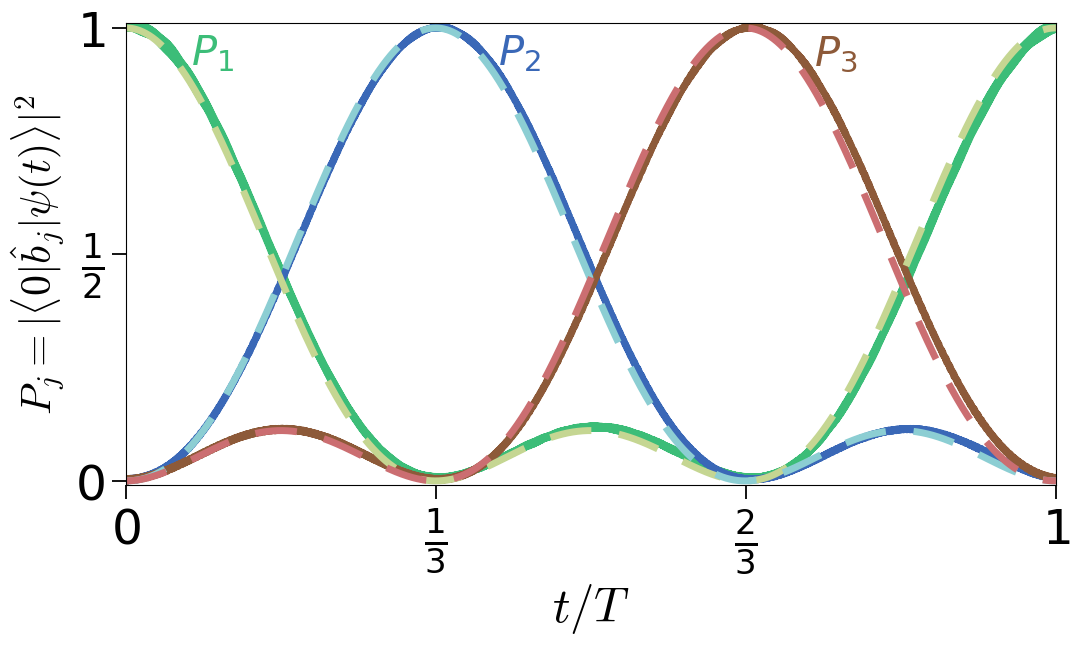

In [44]:
#parameters
Ej = phi0**2/Lj/h
Ec = e**2/2/Cj_value/h
print('wj', wj_value)
print('Ej/h',Ej/2/np.pi,'Ec/h',Ec/2/np.pi, 'Ej/Ec',Ej/Ec)
JY20 = JY_quantum_NL(Cj,Cc,Cg,R,Ldiag,2,0,phi)
T = 2*np.pi/np.sqrt(3)/np.abs(JY20)
print('phase',np.angle(JY20)*6/np.pi)

filename = 'Arrays/populations_Cj={0:.2f}_Cc={1:.2f}_Cg={2:.2f}_R={3:.2f}_phi={4:.2f}.npz'.format(Cj*10**6,Cc/Cj,Cg/Cj,R,phi/np.pi)
loaded_data = np.load(filename)
n0ev = loaded_data['n0']
n1ev = loaded_data['n1']
n2ev = loaded_data['n2']
n0eveff = loaded_data['n0eff']
n1eveff = loaded_data['n1eff']
n2eveff = loaded_data['n2eff']

t = T+.1
step = 0.01
tlist = np.arange(0,t+step,step)
fig= plt.figure()
plt.rcParams['figure.figsize'] = [12, 6]
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0.1)
ax1 = gs.subplots()

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

from matplotlib import rc
import matplotlib.pylab as plt


tlist = tlist/t
ax1.plot(tlist,n0ev,color=lighten_color(a_green,1),marker='None',markevery=2000,markerfacecolor='None',markersize=12,linewidth=5)
ax1.plot(tlist,n1ev,color=lighten_color(a_blue,1),marker='None',markevery=2000,markerfacecolor='None',markersize=12,linestyle='solid',linewidth=5)
ax1.plot(tlist,n2ev,color=lighten_color(a_brown,1),marker='None',markevery=2000,markerfacecolor='None',markersize=12,linestyle='solid',linewidth=5)
ax1.plot(tlist,n0eveff,color=lighten_color(a_green2,.6),linewidth=5,linestyle=(0, (6, 4)))
ax1.plot(tlist,n1eveff,color=lighten_color(a_blue2,.6),linewidth=5,linestyle=(0, (6, 4)))
ax1.plot(tlist,n2eveff,color=lighten_color(a_brown2,.6),linewidth=5,linestyle=(0, (6, 4)))

ls = 18
ax1.tick_params(axis='both', which='major', labelsize=ls,top=False,right=False,direction='out',pad=5)
ax1.tick_params(axis='both', which='minor', labelsize=ls,top=False,right=False,direction='out',pad=5)
ax1.minorticks_on()
ax1.yaxis.set_tick_params(which='minor',length=0)
ax1.yaxis.set_tick_params(which='major',length=10,width=1.3)
ax1.xaxis.set_tick_params(which='minor',length=0)
ax1.xaxis.set_tick_params(which='major',length=10,width=1.3)


xtick_labels = [r'$0$', r'$\frac{1}{3}$', r'$\frac{2}{3}$', r'$1$']
x = np.arange(0,1.01,1/3)
ax1.set_xticks(x)
ax1.set_xticklabels(xtick_labels,fontweight='normal',fontsize=35)
ytick_labels = [r'$0$', r'$\frac{1}{2}$', r'$1$']
y = np.arange(0,1.01,1/2)
ax1.set_yticks(y)
ax1.set_yticklabels(ytick_labels,fontweight='normal',fontsize=35)

ax1.set_ylabel(r'$ P_j = |\langle 0|\hat{b}_j|\psi(t)\rangle|^2 $',fontsize=30,weight='normal',labelpad=5,math_fontfamily='cm')
ax1.set_xlabel(r'$t/T$',fontsize=35,weight='normal',math_fontfamily='cm')

ax1.text(0.07, .91, r'$P_1$', transform=ax1.transAxes, size=30, weight='normal',color=a_green)
ax1.text(0.4, .91, r'$P_2$', transform=ax1.transAxes, size=30, weight='normal',color=a_blue)
ax1.text(0.74, .91, r'$P_3$', transform=ax1.transAxes, size=30, weight='normal',color=a_brown)

ax1.set_xlim(0,1)
ax1.set_ylim(-.01,1.01)
plt.show()